In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import matplotlib.pyplot as plt
plt.rc('axes', axisbelow=True, grid=True)
plt.rc('grid', c='w', ls=':')
plt.rc('font', family='serif', size=11)
plt.rc('image', cmap='gray')
plt.rc('axes.spines', bottom=False, left=False, top=False, right=False)
plt.rc('savefig', bbox='tight', pad_inches=0.1, format='pdf')
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

In [3]:
from itertools import combinations

from scipy.ndimage import binary_fill_holes

from skimage import img_as_ubyte
from skimage.color import rgb2gray, rgb2hsv
from skimage.draw import polygon, circle_perimeter
from skimage.feature import canny
from skimage.filters import median
from skimage.morphology import binary_closing, binary_opening
from skimage.morphology import binary_dilation, binary_erosion
from skimage.morphology import disk, square
from skimage.morphology import remove_small_holes
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border 

In [4]:
train_path = '../input/trimino/'
train_names = {
    'Beginner': ['Pict_1_1.bmp', 'Pict_1_2.bmp'],
    'Intermediate': ['Pict_2_1.bmp', 'Pict_2_2.bmp', 'Pict_2_3.bmp'],
    'Expert': ['Pict_3_1.bmp', 'Pict_3_2.bmp', 'Pict_4_1.bmp', 'Pict_4_2.bmp']
}
all_images = [np.array(Image.open(train_path+name)) for name in sum(train_names.values(), [])]

In [5]:
def to1channel(img, mode='r'):
    '''
    Args:
        img, array: (N, M, 3) 8-bit RGB image
        mode, str: how to perform conversion:
          'r' - red channel only
          'g' - grayscale
          's' - saturation
          'v' - value
    Returns:
        img_output: (N, M) 8-bit image
    '''
    if mode == 'r':
        return img[:, :, 0]
    elif mode == 'g':
        return img_as_ubyte(rgb2gray(img))
    elif mode == 's':
        return img_as_ubyte(rgb2hsv(img)[:, :, 1])
    elif mode == 'v':
        return img_as_ubyte(rgb2hsv(img)[:, :, 2])

In [6]:
def points2dists(triangle_vertices, sqrt=False):
    trs = triangle_vertices.copy()
    trs[:, :2] -= trs[:, 2][:, None]
    trs[:, 2] = trs[:, 0] - trs[:, 1]
    sqr_dists = (trs ** 2).sum(axis=-1)
    if sqrt:
        return np.sqrt(sqr_dists)
    else:
        return sqr_dists
    
def farthest3(points):
    inds = np.array(list(combinations(range(len(points)), 3)))
    dists = points2dists(points[inds]).sum(axis=1)
    far_inds = inds[dists.argmax()]
    return points[far_inds]

def poly2inds(vertices):
    inds = polygon(vertices[:, 0], vertices[:, 1])
    return inds

def reverse_erosion_triangle(corners, center, erosion_radius):
    dirs = (corners - center) / np.sqrt(((corners - center) ** 2).sum(axis=1, keepdims=True))
    return np.round(corners + dirs * erosion_radius * 2).astype(int)

def iou_sets(set1, set2):
    return len(set1 & set2) / len(set1 | set2)

In [7]:
def mask_objects(img, sigma=1, closing_radius=3,
                 erosion_radius=20, remove_border=True):
    img = to1channel(img)
    img = canny(img, sigma=sigma)
    img = binary_closing(img, disk(closing_radius))
    img = binary_fill_holes(img, disk(1))
    if remove_border:
        img = clear_border(img)
    img = binary_erosion(img, disk(erosion_radius))
    return img

In [9]:
def build_triangles(bin_mask, iou_theshold=0.8, erosion_radius=20):
    labels = label(bin_mask)
    centers, vertices = [], []
    for prop in regionprops(labels):
        if prop.area < 50:
            continue
        center = prop.centroid
        cs = prop.coords
        bbox = prop.bbox
        border_mask = (
            (cs[:, 0] == bbox[0]) | (cs[:, 0] == bbox[2] - 1) | 
            (cs[:, 1] == bbox[1]) | (cs[:, 1] == bbox[3] - 1)
        )
        corners = farthest3(cs[border_mask])
        iou = iou_sets(set((row, col) for row, col in cs), # obj
                       set(zip(*poly2inds(corners))))  # circumscribed triangle
        if (iou > iou_theshold):
            centers.append(center)
            big_corners = reverse_erosion_triangle(corners, center, erosion_radius)
            vertices.append(big_corners)
    return np.array(centers), np.array(vertices)

In [10]:
def triangles2mask(shape, vertices, erosion_radius=0):
    mask = np.zeros(shape, dtype=bool)
    for triangle in vertices:
        inds = poly2inds(triangle)
        mask[inds] = 1
    if erosion_radius > 0:
        mask = binary_erosion(mask, disk(erosion_radius))
    return mask

In [11]:
def find_dots(img, vertices, median_kernel=5, sigma=1, low=10, high=40, closing_size=1):
    img = median(img, square(median_kernel))
    mask = triangles2mask(img.shape, vertices, 2)
    img = canny(img, sigma=sigma, low_threshold=low, high_threshold=high, mask=mask)
    img = binary_closing(img, disk(closing_size))
    dots = np.logical_xor(remove_small_holes(img, area_threshold=200), img)
    centers = np.array([prop.centroid for prop in regionprops(label(dots))])
    return centers

def count_dots(vertices, centers, dots):
    counts = []
    dot_set = set((row, col) for row, col in np.round(dots).astype(int))
    for triangle in vertices:
        cur_dots = set(zip(*poly2inds(triangle))) & dot_set
        cur_dots = np.array(list(cur_dots))
        cur_cnt = ((triangle - cur_dots[:, None]) ** 2).sum(axis=-1).argmin(axis=1)
        counts.append([(cur_cnt == i).sum() for i in range(3)])
    return np.array(counts)

In [13]:
def plot(main_image, bin_mask, centers, vertices, gr_image):
    plt.figure(figsize=(8, 6), dpi=200)

    plt.subplot(221)
    plt.axis('off')
    plt.imshow(main_image)

    plt.subplot(222)
    # plt.axis('off')
    plt.imshow(bin_mask)

    plt.subplot(223)
    # plt.axis('off')
    plt.imshow(main_image)
    plt.scatter(centers[:, 1], centers[:, 0], marker='*', c='lime')
    for triangle in vertices:
        triangle_plot = plt.Polygon(triangle[:, [1, 0]], fill=False,
                                    color='lime', lw=1)
        plt.gca().add_patch(triangle_plot)

    plt.subplot(224)
    plt.axis('off')

    plt.imshow(np.zeros_like(gr_image))
    for triangle in vertices:
        triangle_plot = plt.Polygon(triangle[:, [1, 0]], fill=False,
                                    color='cyan', lw=1)
        plt.gca().add_patch(triangle_plot)
    plt.scatter(dots[:, 1], dots[:, 0], marker='o', color='w', s=1)
    plt.tight_layout()
    plt.show()

# Пример полной работы

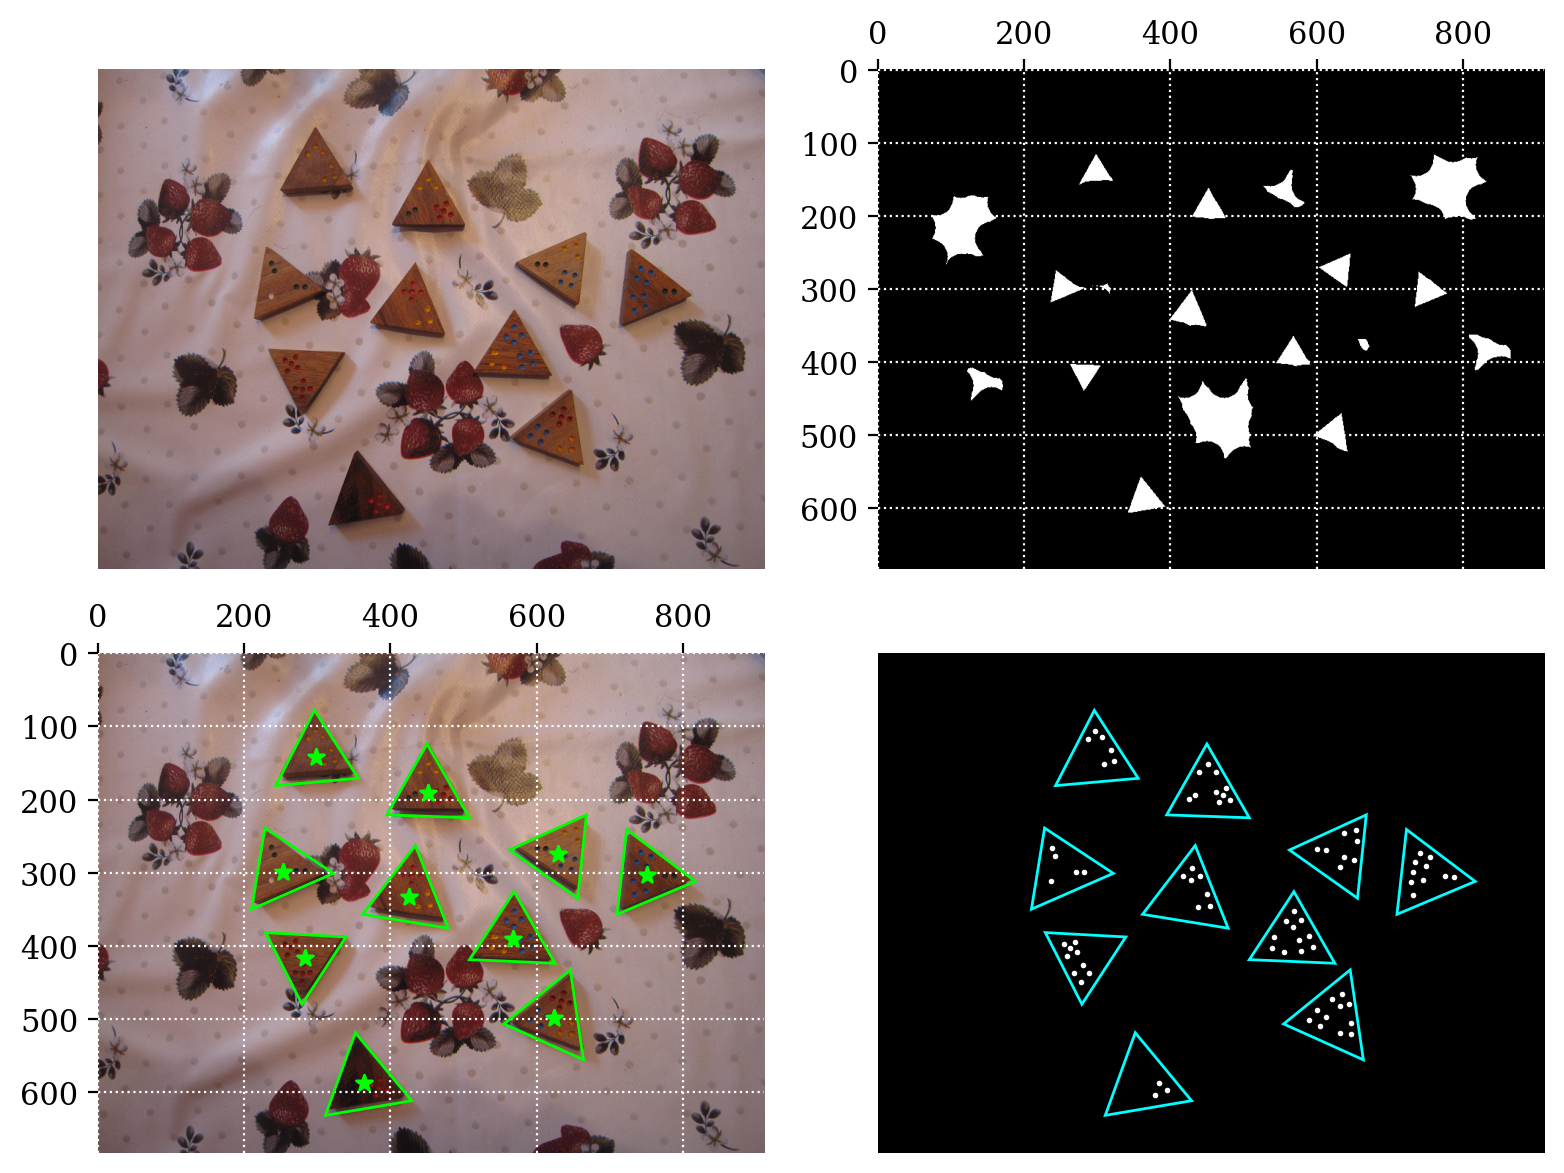

In [14]:
fpath = '../input/trimino/Pict_3_1.bmp'
output_name = 'output.txt'
main_image = np.array(Image.open(fpath))
bin_mask = mask_objects(main_image)
centers, vertices = build_triangles(bin_mask)
gr_image = to1channel(main_image, 's')
dots = find_dots(gr_image, vertices)
counts = count_dots(vertices, centers, dots)
output_list = [f'{len(centers)}\n']
for c, cnt in zip(np.round(centers).astype(int), counts):
    output_list.append(f'{c[1]}, {c[0]}; {cnt[0]}, {cnt[1]}, {cnt[2]}\n')
with open(output_name, 'w') as fout:
    fout.writelines(output_list)
plot(main_image, bin_mask, centers, vertices, gr_image)

# Обзор алгоритма

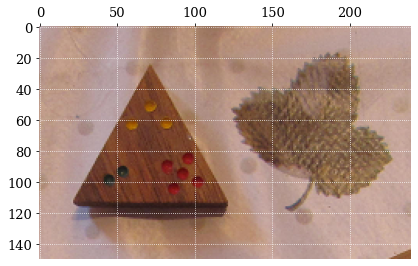

In [97]:
main_image = np.array(Image.open('../input/trimino/Pict_3_1.bmp'))
main_image = main_image[100:250, 380:620]
plt.rc('font', family='serif', size=13)
plt.imshow(main_image)
plt.tight_layout()
plt.savefig('fragment_input')

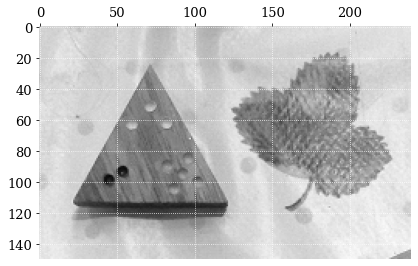

In [98]:
img = to1channel(main_image)
plt.imshow(img)
plt.tight_layout()
plt.savefig('fragment_gray')

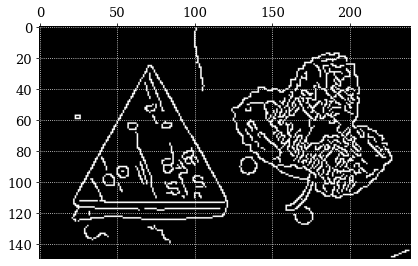

In [99]:
img = canny(img)
plt.imshow(img)
plt.tight_layout()
plt.savefig('fragment_canny')

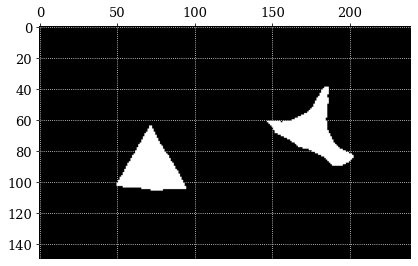

In [100]:
bin_mask = mask_objects(main_image)
plt.imshow(bin_mask)
plt.gca().xaxis.set_ticks_position('top')
plt.tight_layout()
plt.savefig('fragment_objects')

In [103]:
labels = label(bin_mask)
tp_fp_fn = np.zeros_like(labels)
for prop in regionprops(labels):
    if prop.area < 50:
        continue
    center = prop.centroid
    cs = prop.coords
    bbox = prop.bbox
    border_mask = (
        (cs[:, 0] == bbox[0]) | (cs[:, 0] == bbox[2] - 1) | 
        (cs[:, 1] == bbox[1]) | (cs[:, 1] == bbox[3] - 1)
    )
    corners = farthest3(cs[border_mask])
    triangle_inds = poly2inds(corners)
    tr_fill = np.zeros_like(labels, dtype=bool)
    tr_fill[triangle_inds] = True
    tp_fp_fn[tr_fill & (labels==prop.label)] = 1
    tp_fp_fn[tr_fill & (labels!=prop.label)] = 2
    tp_fp_fn[~tr_fill & (labels==prop.label)] = 3
    iou = iou_sets(set((row, col) for row, col in cs), # obj
                   set(zip(*triangle_inds)))  # circumscribed triangle
    print(iou)

0.43067226890756305
0.8802456499488229


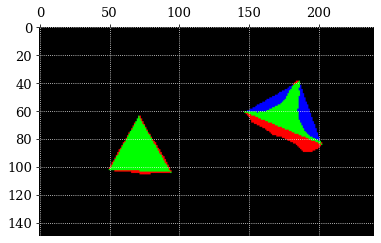

In [116]:
from skimage.color import label2rgb
iou_ill = label2rgb(tp_fp_fn, colors=['lime', 'blue', 'red'], alpha=1, bg_label=0)
plt.imshow(iou_ill)
plt.savefig('fragment_iou')

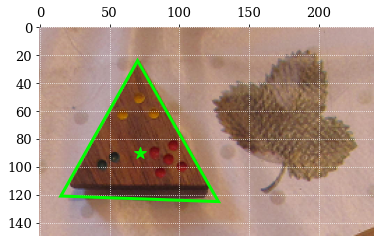

In [117]:
centers, vertices = build_triangles(bin_mask)
plt.imshow(main_image)
plt.scatter(centers[:, 1], centers[:, 0], marker='*', c='lime', s=150)
for triangle in vertices:
    triangle_plot = plt.Polygon(triangle[:, [1, 0]], fill=False,
                                color='lime', lw=3)
    plt.gca().add_patch(triangle_plot)
plt.savefig('fragment_triangle')

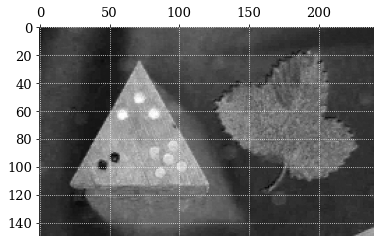

In [122]:
gr_image = to1channel(main_image, 's')
plt.imshow(gr_image)
plt.savefig('fragment_saturation')

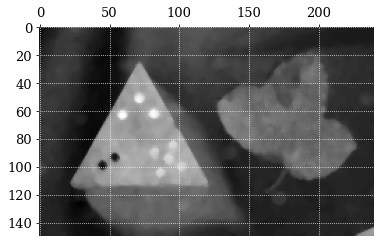

In [125]:
img = median(gr_image, square(5))
plt.imshow(img)
plt.savefig('fragment_median')

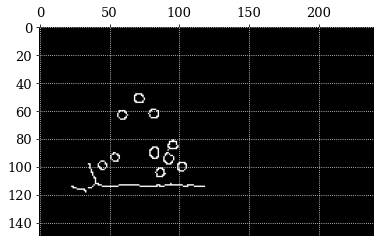

In [126]:
mask = triangles2mask(img.shape, vertices, 2)
img = canny(img, sigma=1, low_threshold=10, high_threshold=40, mask=mask)
plt.imshow(img)
plt.savefig('fragment_canny_2')

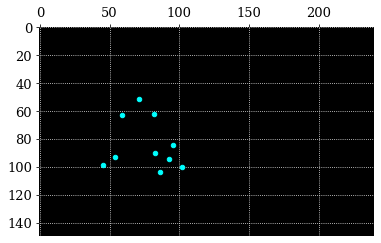

In [134]:
dots = find_dots(gr_image, vertices)
plt.imshow(np.zeros_like(gr_image))
plt.scatter(dots[:, 1], dots[:, 0], marker='o', color='cyan', s=20)
plt.savefig('fragment_dots')

In [137]:
counts = count_dots(vertices, centers, dots)
output_list = [f'{len(centers)}\n']
for c, cnt in zip(np.round(centers).astype(int), counts):
    output_list.append(f'{c[1]}, {c[0]}; {cnt[0]}, {cnt[1]}, {cnt[2]}\n')
with open(output_name, 'w') as fout:
    fout.writelines(output_list)
print(''.join(output_list))

1
72, 91; 3, 2, 5



# Еще примеры

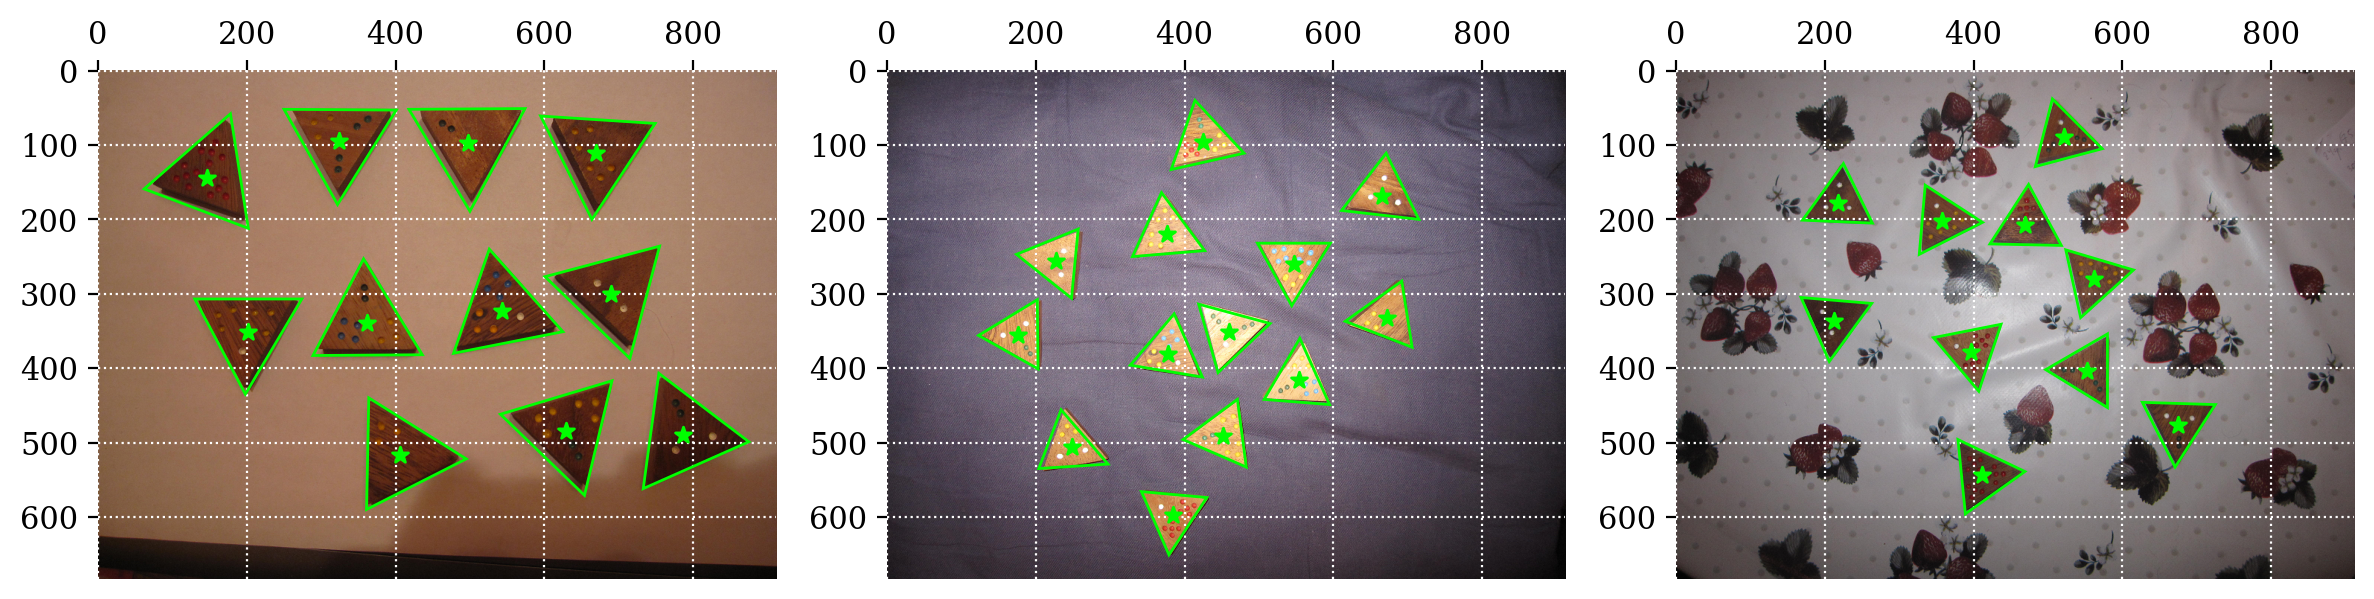

In [20]:
plt.figure(figsize=(12, 6.5), dpi=200)

for sp, i in enumerate([0, 2, -2]):
    main_image = all_images[i]
    bin_mask = mask_objects(main_image)
    centers, vertices = build_triangles(bin_mask)
#     gr_image = to1channel(main_image, 's')
#     dots = find_dots(gr_image, vertices)
    
    plt.subplot(1, 3, sp + 1)
    plt.imshow(main_image)
    plt.scatter(centers[:, 1], centers[:, 0], marker='*', c='lime')
    for triangle in vertices:
        triangle_plot = plt.Polygon(triangle[:, [1, 0]], fill=False,
                                    color='lime', lw=1)
        plt.gca().add_patch(triangle_plot)
plt.tight_layout()
plt.savefig('triple_segmantation')

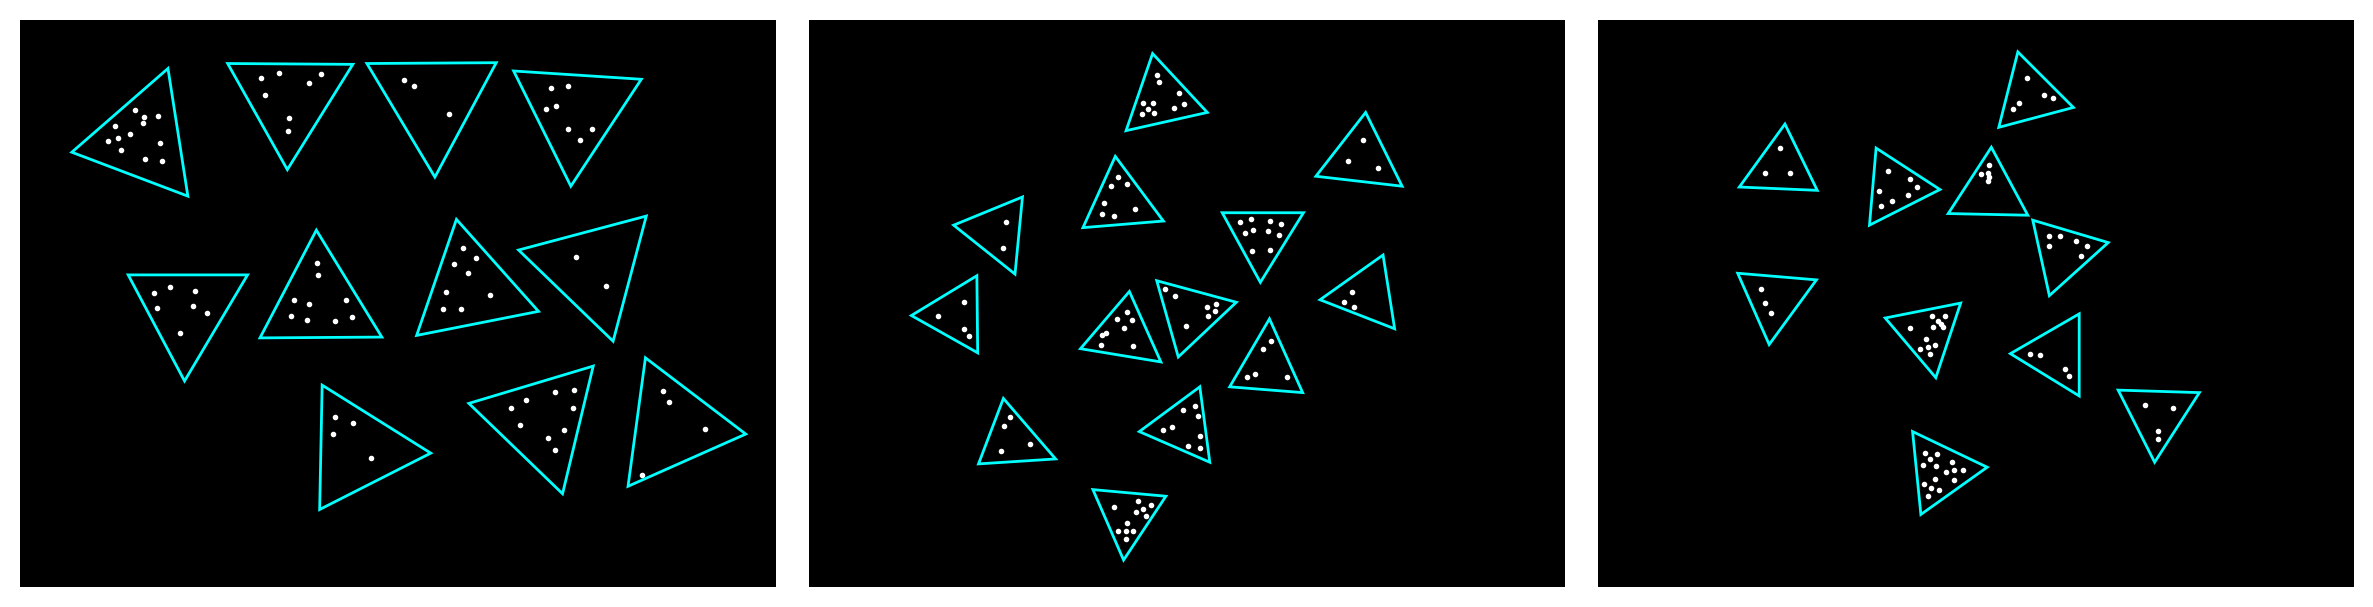

In [21]:
plt.figure(figsize=(12, 6.5), dpi=200)

for sp, i in enumerate([0, 2, -2]):
    main_image = all_images[i]
    bin_mask = mask_objects(main_image)
    centers, vertices = build_triangles(bin_mask)
    gr_image = to1channel(main_image, 's')
    dots = find_dots(gr_image, vertices)
    
    plt.subplot(1, 3, sp + 1)
    plt.axis('off')
    plt.imshow(np.zeros_like(gr_image))
    for triangle in vertices:
        triangle_plot = plt.Polygon(triangle[:, [1, 0]], fill=False,
                                    color='cyan', lw=1)
        plt.gca().add_patch(triangle_plot)
    plt.scatter(dots[:, 1], dots[:, 0], marker='o', color='w', s=1)
plt.tight_layout()
plt.savefig('triple_dots')